<a href="https://colab.research.google.com/github/AndreiAf02/Math574_Project/blob/main/Cholera_Fitter_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
%matplotlib inline
import arviz as az
import seaborn as sns

from pymc.ode import DifferentialEquation
from scipy.integrate import odeint

In [2]:
path_to_data = 'https://raw.githubusercontent.com/AndreiAf02/Math574_Project/main/'

In [3]:
data_cholera = pd.read_csv(path_to_data + "Zimbabwe_Cholera.csv", sep=",", header=0)
data_cholera = data_cholera[21:]
data_cholera = data_cholera[['Date', 'Zimbabwe', 'Zimb_cumul']]
data_cholera['Zimb_cumul'] = np.cumsum(data_cholera['Zimbabwe'])
data_cholera = data_cholera.reset_index(drop=True)
data_cholera

,Date,Zimbabwe,Zimb_cumul
0,03-Sep-23,3,3
1,08-Sep-23,30,33
2,17-Sep-23,38,71
3,22-Sep-23,58,129
4,30-Sep-23,204,333
5,07-Oct-23,343,676
6,13-Oct-23,339,1015
7,20-Oct-23,215,1230
8,28-Oct-23,372,1602
9,06-Nov-23,526,2128


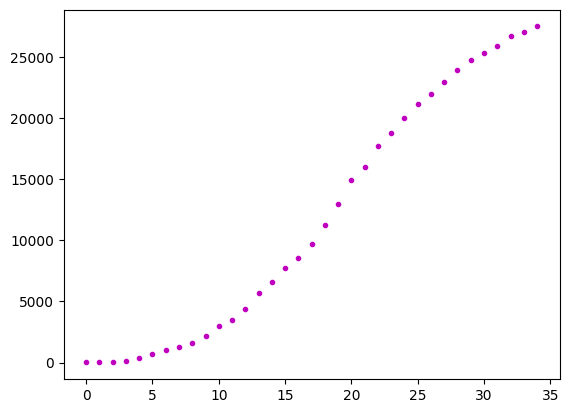

In [4]:
plt.plot(data_cholera['Zimb_cumul'], 'm.')

In [27]:
def Cholera_model(y,t, a_val, gamma, d, q_1, q_2, p, thresh):
    S,I,A,B=y
    if B < thresh:
      a = 0
    else:
      a = a_val
    dS_dt=-(1-c_s)*(1-c_h)*a*(B-thresh)*S
    dI_dt=(1-p)*(1-c_s)*(1-c_h)*a*(B-thresh)*S - (gamma+d)*I
    dA_dt=p*(1-c_s)*(1-c_h)*a*(B-thresh)*S - gamma*A
    dB_dt = (1-c_f)*(q_1*I+q_2*A)
    return([dS_dt,dI_dt,dA_dt, dB_dt])



def Cholera_solver(mod, t, a_val, gamma, d, q_1, q_2, p, thresh):
    Solution = pd.DataFrame()
    sol=scipy.integrate.odeint(mod,[S0,I0,A0,B0],t,args=(a_val,gamma, d, q_1, q_2, p, thresh))
    sol=np.array(sol)
    Solution['time']=t
    Solution['S(t)']=sol[:,0]
    Solution['I(t)']=sol[:,1]
    Solution['A(t)']=sol[:,2]
    Solution['B(t)']=sol[:,2]
    return Solution


def Cholera_fitter(mod, t, a_val, gamma, d, q_1, q_2, p, thresh, data, label):
    SumSq = pd.DataFrame(columns = ['SumSquared'])
    Solution = pd.DataFrame()
    sol=scipy.integrate.odeint(mod,[S0,I0,A0,B0],t,args=(a_val,gamma, d, q_1, q_2, p, thresh))
    sol=np.array(sol)
    Solution['time']=t
    Solution['S(t)']=sol[:,0]
    Solution['I(t)']=sol[:,1]
    Solution['A(t)']=sol[:,2]
    Solution['B(t)']=sol[:,2]
    Sum=0
    for j in range(len(data)):
      for i in range(len(t)):
        if Solution['time'][i]==j:
          diff = (Solution['I(t)'][i]-data[label][j])**2
        else:
          diff = 0
        Sum = Sum+diff
    return Sum
    print(Sum)



In [8]:
pop = 350000
p=0.90

dt=1
max_time = 35
t = np.linspace(0,max_time,int(max_time/dt)+1)

a_val = 0.0000375
thresh = 10000
gamma = 0.96
d = 0.2
q_1 = 0.05
q_2 = 0.019

c_s=0
c_h=0
c_f = 0

I0 = 3
S0 = pop-I0
A0=0
B0=10075

output = Cholera_solver(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh)

fit = Cholera_fitter(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh, data_cholera, 'Zimbabwe')
fit

2996851.14692226

In [48]:
pop = 350000
p=0.90

dt=1
max_time = 35
t = np.linspace(0,max_time,int(max_time/dt)+1)

a_vals = np.linspace(0.000055, 0.000065, 11) #0.0000375
thresh = 10000
gamma_vals = np.linspace(1.0, 1.2, 21) #0.96
d = 0.2
q_1_vals = np.linspace(0.0, 0.2, 21) #0.05
q_2_vals = np.linspace(0.0, 0.01, 11) #0.009


I0 = 3
S0 = pop-I0
A0=0
B0=10075

c_s=0
c_h=0
c_f = 0

SumSq = []
Aval = []
Gamma = []
Q1 = []
Q2 = []

for a_val in a_vals:
  for gamma in gamma_vals:
    for q_1 in q_1_vals:
      for q_2 in q_2_vals:
        Result = Cholera_fitter(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh, data_cholera, 'Zimbabwe')
        Aval.append(a_val)
        Gamma.append(gamma)
        Q1.append(q_1)
        Q2.append(q_2)
        SumSq.append(Result)

ParamFit = pd.DataFrame([Aval, Gamma, Q1, Q2, SumSq]).T
ParamFit.columns=['a_val', 'Gamma', 'q_1', 'q_2', 'SumSq']
# print(ParamFit)

BestFit = pd.DataFrame()
BestFit = ParamFit.loc[ParamFit['SumSq']==ParamFit['SumSq'].min()]

print(BestFit)
BestFit = BestFit.to_numpy()



          a_val  Gamma   q_1  q_2         SumSq
44484  0.000064   1.03  0.12  0.0  1.422179e+06


In [49]:
BestFit2 = BestFit

a_val = BestFit[0,0]
gamma = BestFit[0,1]
q_1 = BestFit[0,2]
q_2 = BestFit[0,3]

print("a_val:", a_val, "gamma:", gamma, "q_1:", q_1, "q_2:", q_2)

output = Cholera_solver(Cholera_model, t, a_val, gamma, d, q_1, q_2, p, thresh)


a_val: 6.4e-05 gamma: 1.03 q_1: 0.12 q_2: 0.0


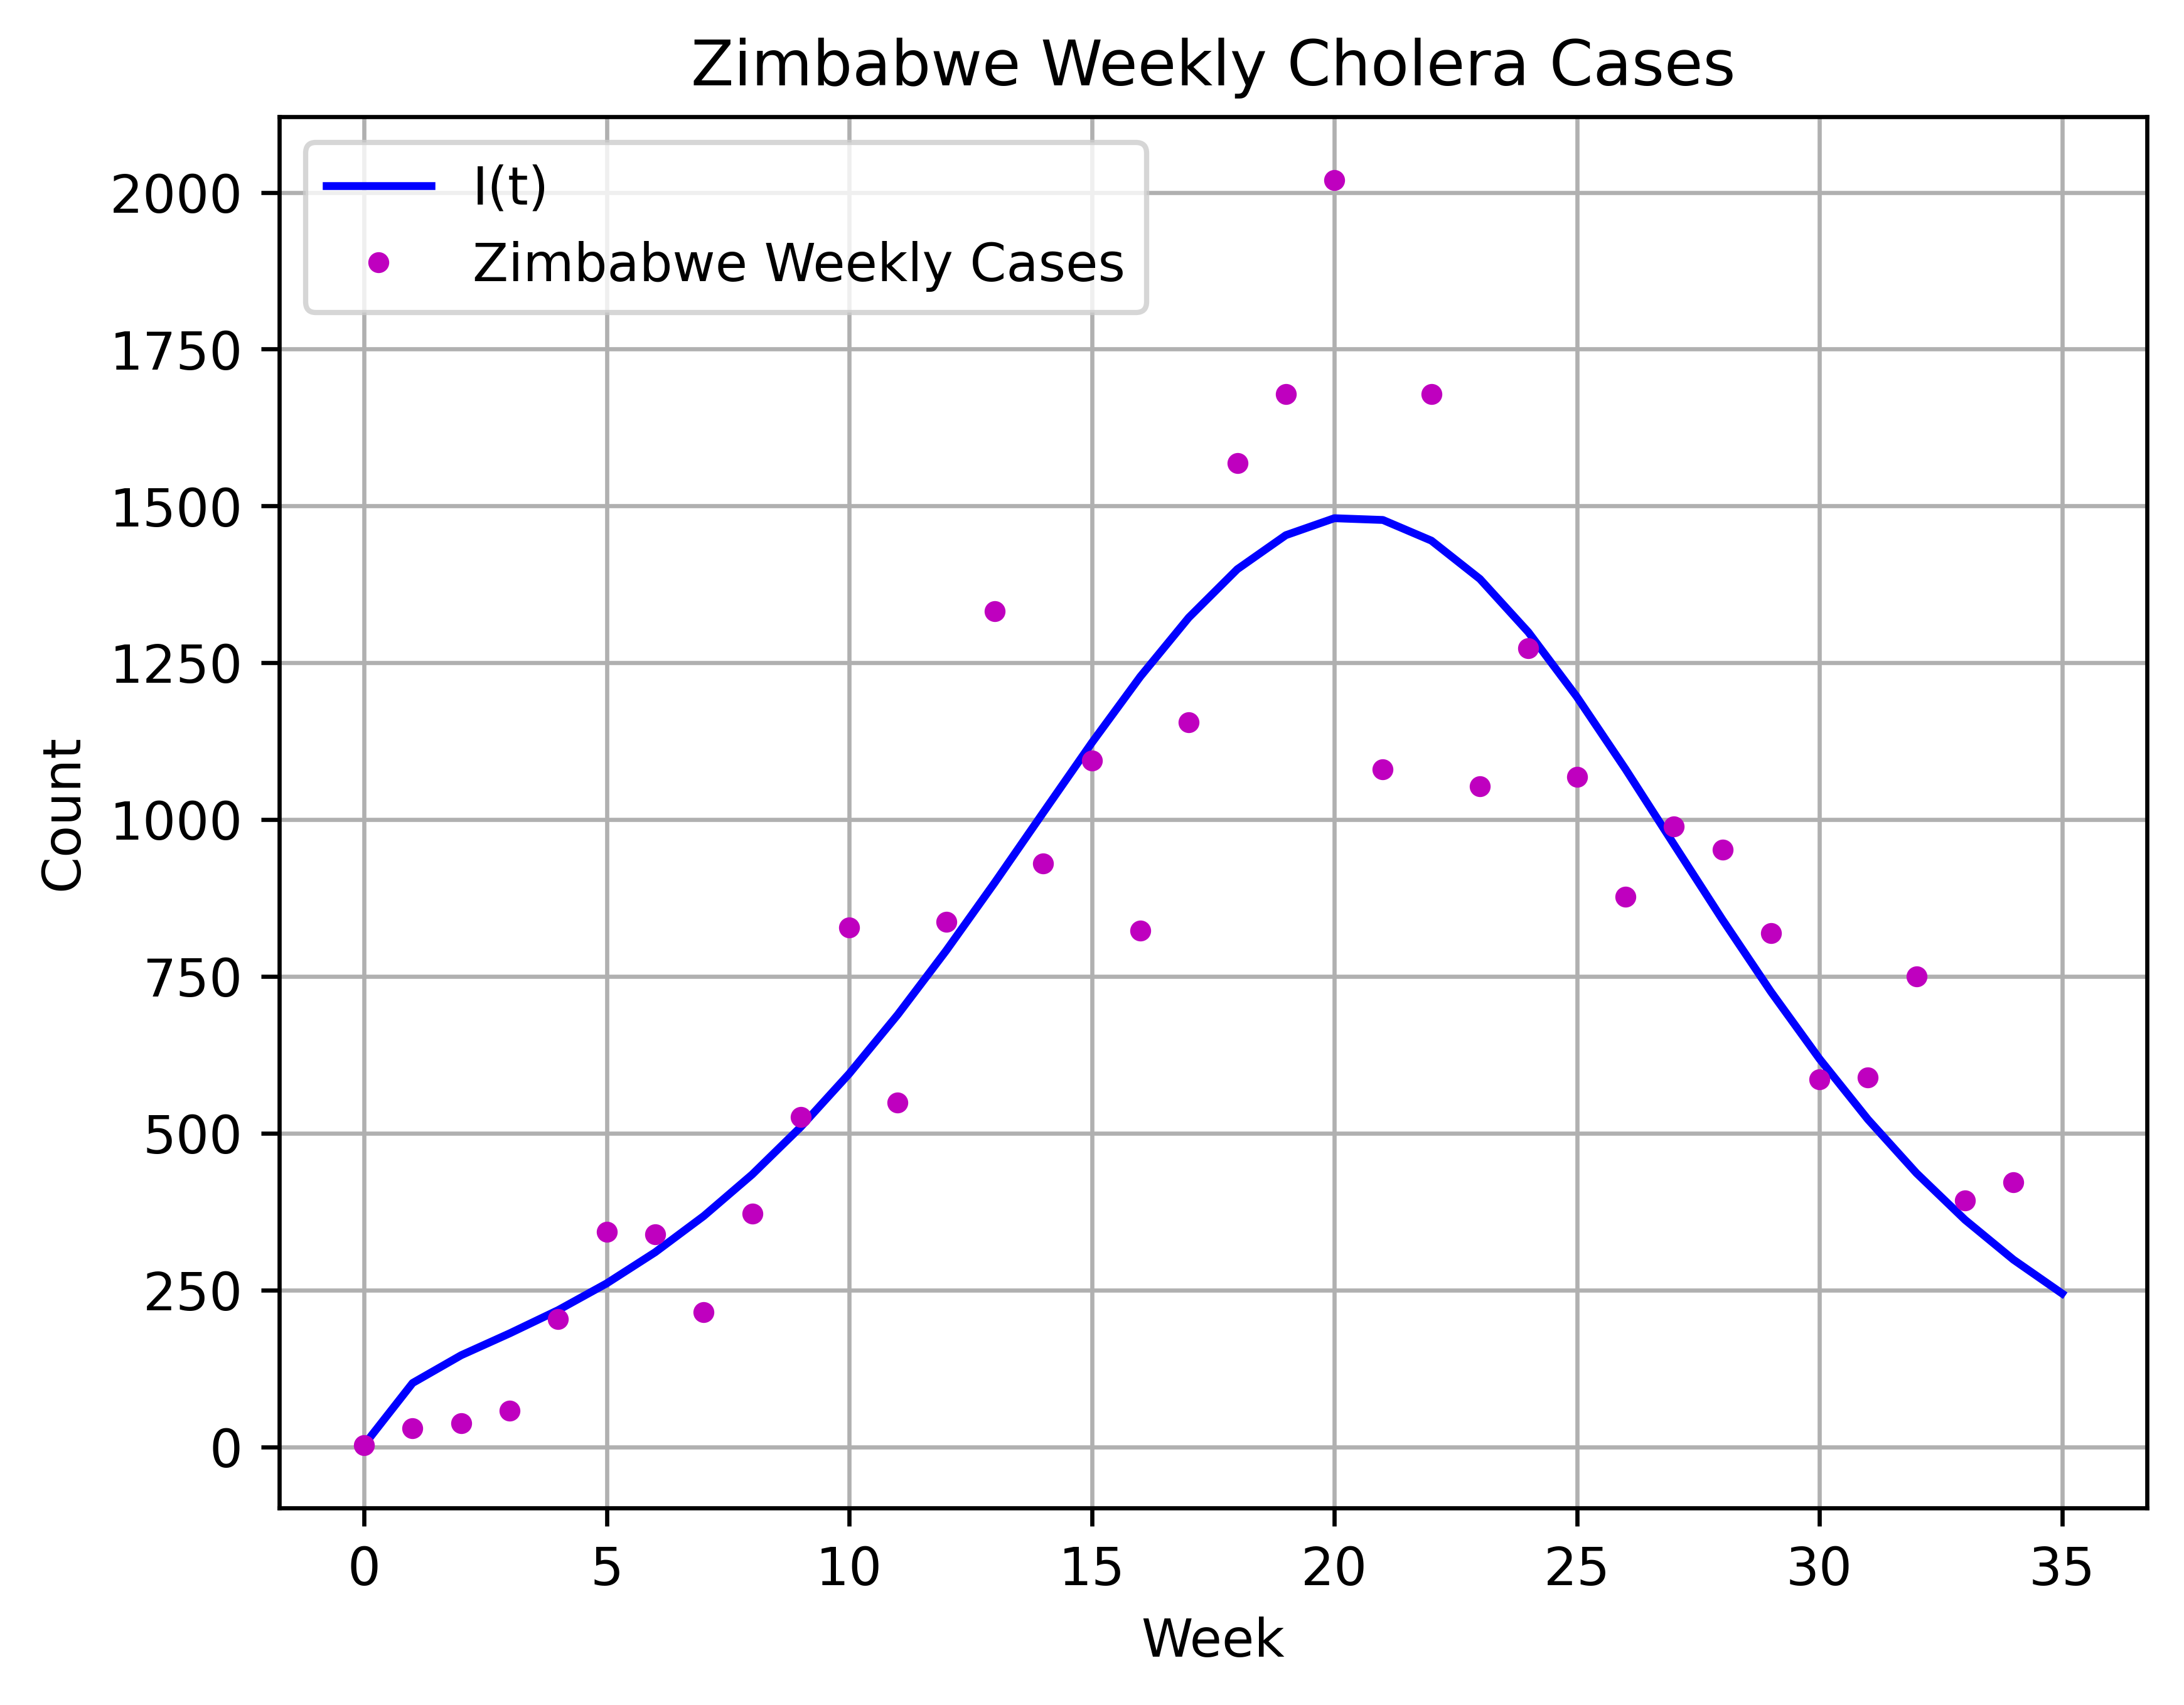

In [50]:
plt.figure(dpi=600)
plt.grid()
plt.title('Zimbabwe Weekly Cholera Cases')
plt.plot(output['time'], output['I(t)'], 'b-', label='I(t)')
plt.plot(data_cholera['Zimbabwe'], 'm.', label='Zimbabwe Weekly Cases')
plt.xlabel('Week')
plt.ylabel('Count')
plt.legend()

## Trust and Cynicism in a population:

In [5]:
def trust(y,t,beta1, beta2, gamma1, gamma2, p):
    N,B,C=y
    dN_dt=-gamma1*N-beta1*B*N -beta2*C*N
    dB_dt= p * gamma1*N + beta1*B*N - gamma2*B
    dC_dt= (1-p) * gamma1*N + beta2*C*N + gamma2*B
    return([dN_dt,dB_dt,dC_dt])

         N(t)      B(t)      C(t)
0    1.000000  0.000000  0.000000
1    0.990020  0.001995  0.007985
2    0.980081  0.003980  0.015939
3    0.970185  0.005953  0.023862
4    0.960331  0.007916  0.031753
..        ...       ...       ...
346  0.007052  0.058818  0.934130
347  0.006945  0.058543  0.934512
348  0.006840  0.058269  0.934891
349  0.006736  0.057996  0.935268
350  0.006634  0.057724  0.935642

[351 rows x 3 columns]


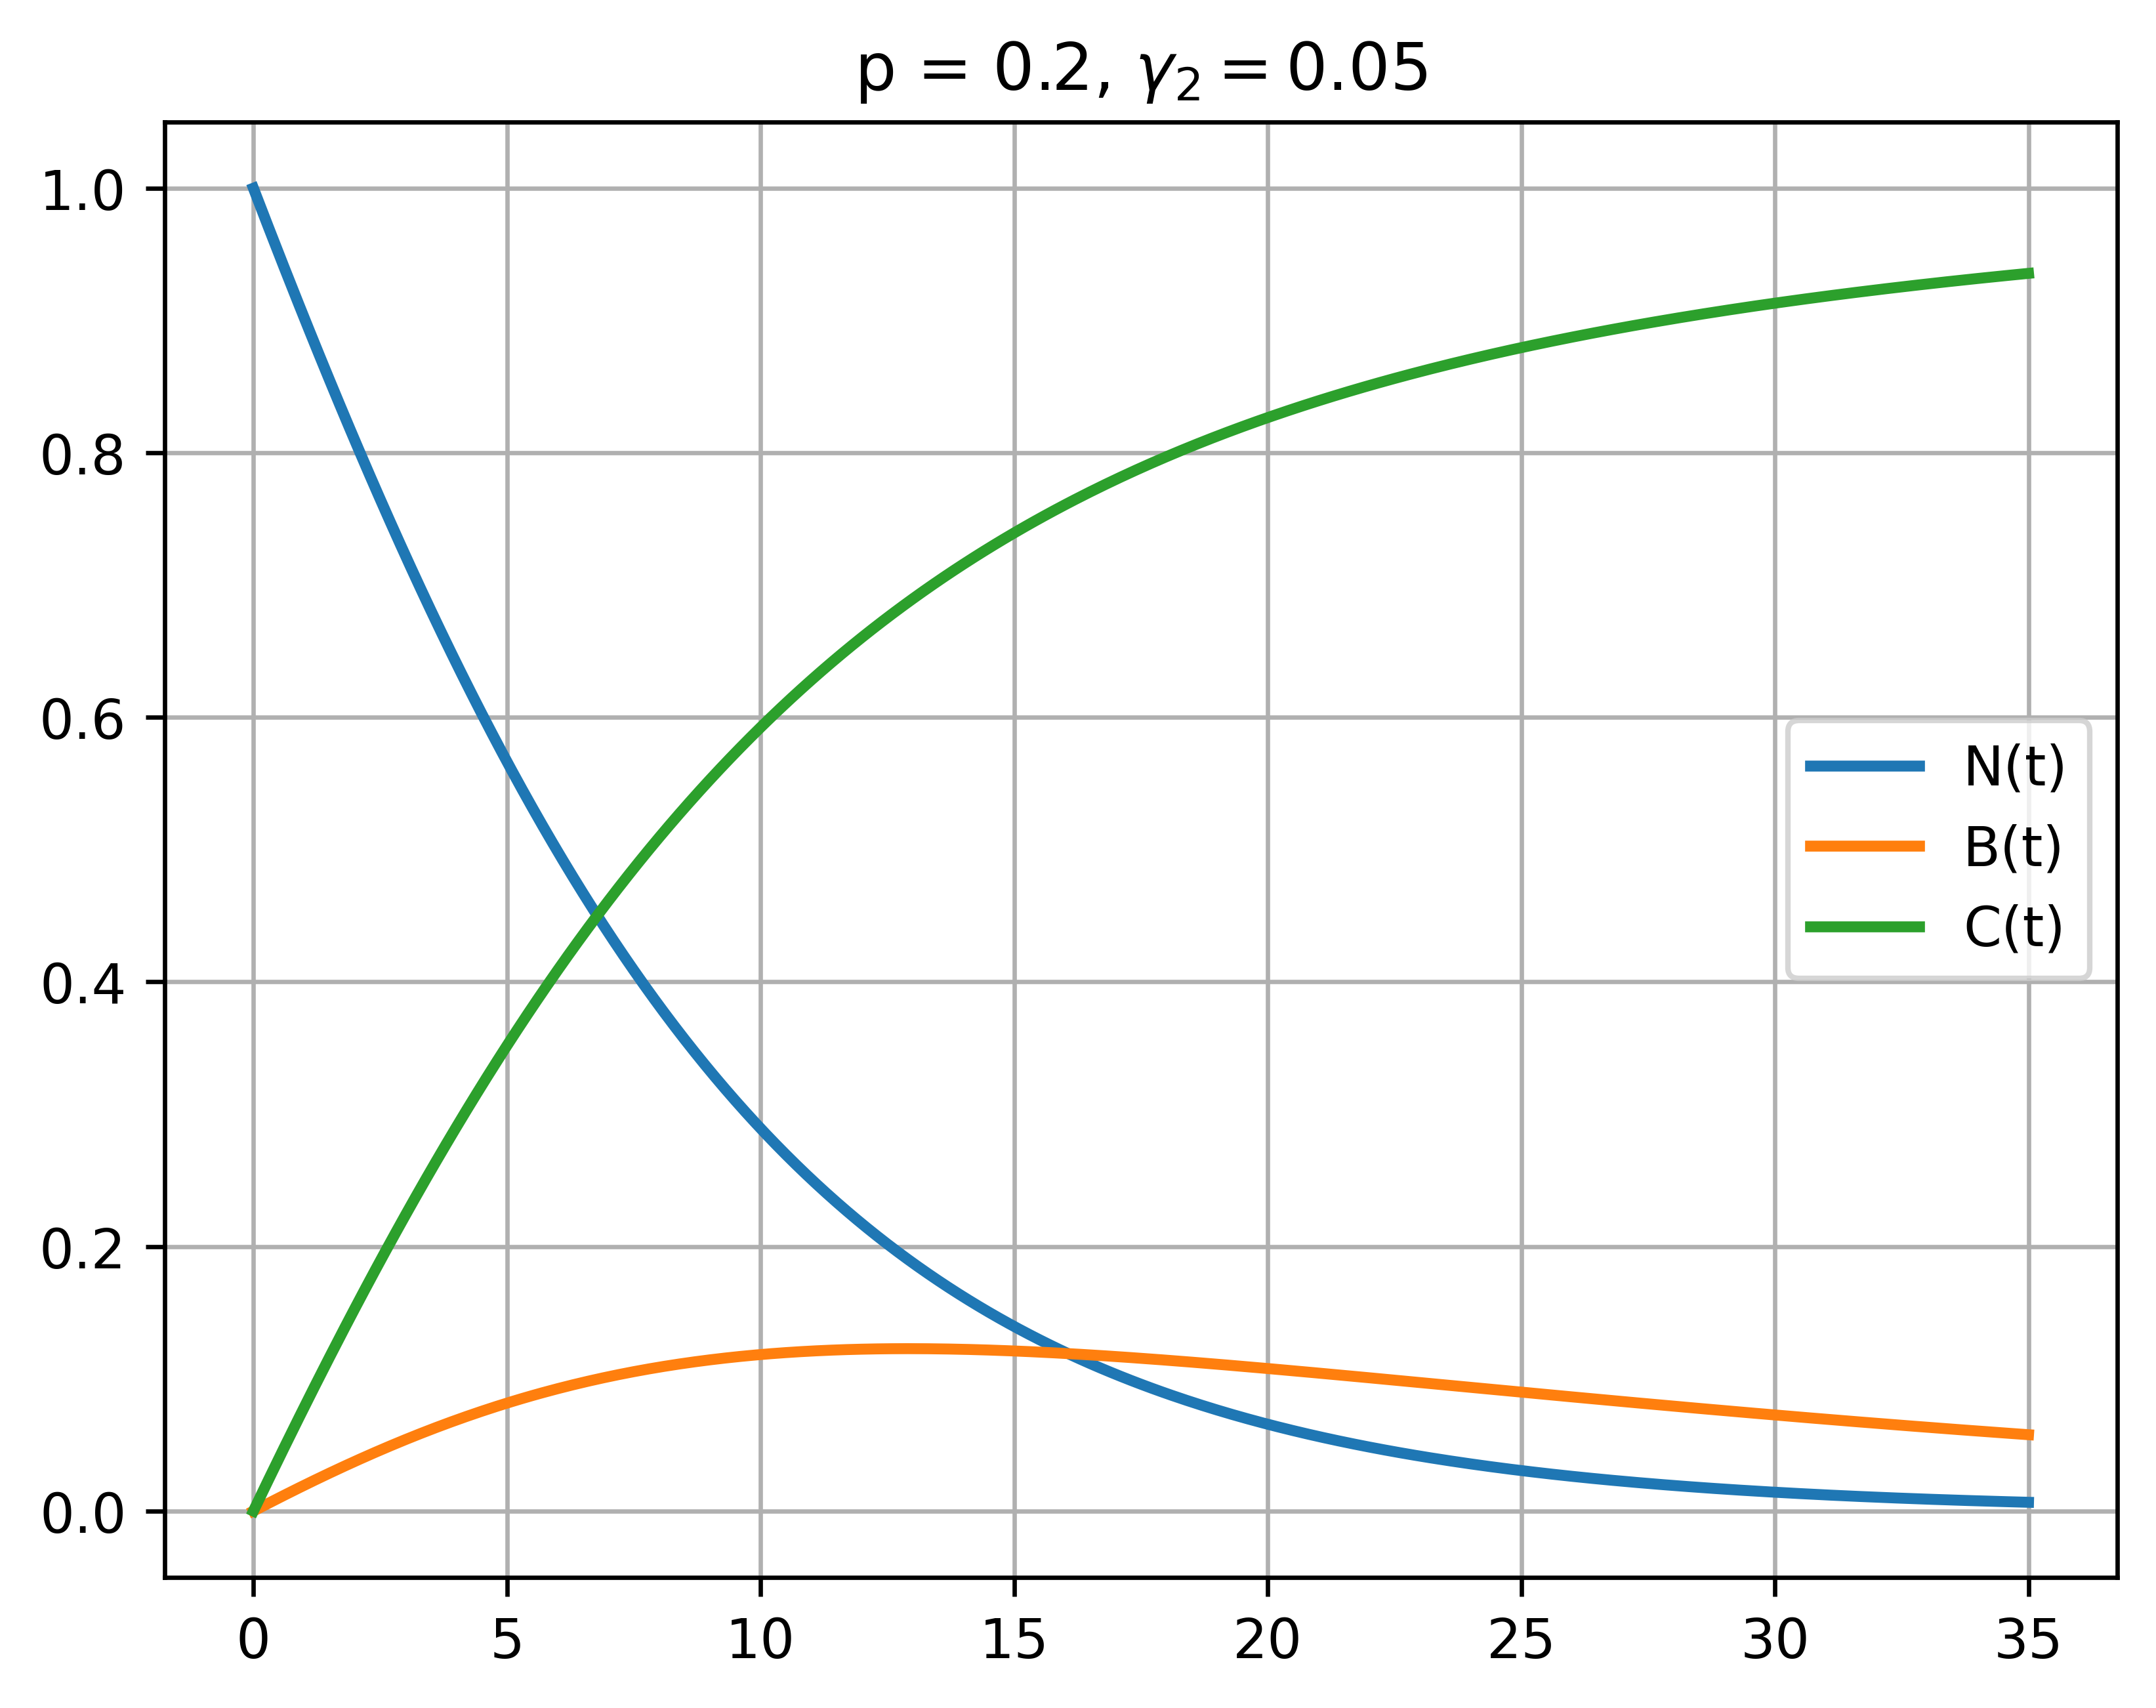

In [91]:
gamma1 = 0.1
beta1 = 0.1
beta2 = 0.05
p = 0.2
gamma2 = 0.05

N0=1
B0=0
C0=0

t = np.linspace(0, 35, 351)

solution = scipy.integrate.odeint(trust,[N0, B0, C0],t,args=(beta1, beta2, gamma1, gamma2, p))
Solution = pd.DataFrame()
Solution['N(t)']=solution[:,0]
Solution['B(t)']=solution[:,1]
Solution['C(t)']=solution[:,2]

print(Solution)

plt.figure(dpi=600)
plt.title('p = '+str(p)+', '+r'$\gamma_2=$'+str(gamma2))
plt.plot(t, Solution['N(t)'], label='N(t)', linewidth=2.0)
plt.plot(t, Solution['B(t)'], label='B(t)', linewidth=2.0)
plt.plot(t, Solution['C(t)'], label='C(t)', linewidth=2.0)
plt.grid()
plt.legend()

## Incorporating the spread of trust and cynicism into disease control modellling:

In [92]:
def Cholera_compliance(y,t, a_val, gamma, d, q_1, q_2, p1, thresh, beta1, beta2, gamma1, gamma2, p2):
    S,I,A,B,N,T,C=y
    if B < thresh:
      a = 0
    else:
      a = a_val
    dS_dt=-(1-0.5*N-T)*(1-0.5*N-T)*a*(B-thresh)*S
    dI_dt=(1-p1)*(1-0.5*N-T)*(1-0.5*N-T)*a*(B-thresh)*S - (gamma+d)*I
    dA_dt=p1*(1-0.5*N-T)*(1-0.5*N-T)*a*(B-thresh)*S - gamma*A
    dB_dt = (1-0.375*N-0.75*T)*(q_1*I+q_2*A)

    dN_dt=-gamma1*N-beta1*T*N -beta2*C*N
    dT_dt= p2 * gamma1*N + beta1*T*N - gamma2*T
    dC_dt= (1-p2) * gamma1*N + beta2*T*N + gamma2*T
    return([dS_dt,dI_dt,dA_dt, dB_dt, dN_dt, dT_dt, dC_dt])



In [96]:
dt=0.1
max_time = 35
t = np.linspace(0,max_time,int(max_time/dt)+1)

a_val = 6.4*10**(-5)
gamma = 1.03
q_1 = 0.12
q_2 = 0.0
p1 = 0.9

I0 = 3
S0 = pop-I0
A0=0
B0=10075

gamma1 = 0.1
beta1 = 0.1
beta2 = 0.05
p2 = 0.2
gamma2 = 0.05


N0=1
T0=0
C0=0

sol=scipy.integrate.odeint(Cholera_compliance,[S0,I0,A0, B0, N0, T0, C0],t,args=(a_val, gamma, d, q_1, q_2, p1, thresh, beta1, beta2, gamma1, gamma2, p2))
Solution = pd.DataFrame()
Solution['S(t)']=sol[:,0]
Solution['I(t)']=sol[:,1]
Solution['A(t)']=sol[:,2]
Solution['B(t)']=sol[:,3]
Solution['N(t)']=sol[:,4]
Solution['T(t)']=sol[:,5]
Solution['C(t)']=sol[:,6]

Solution4 = Solution

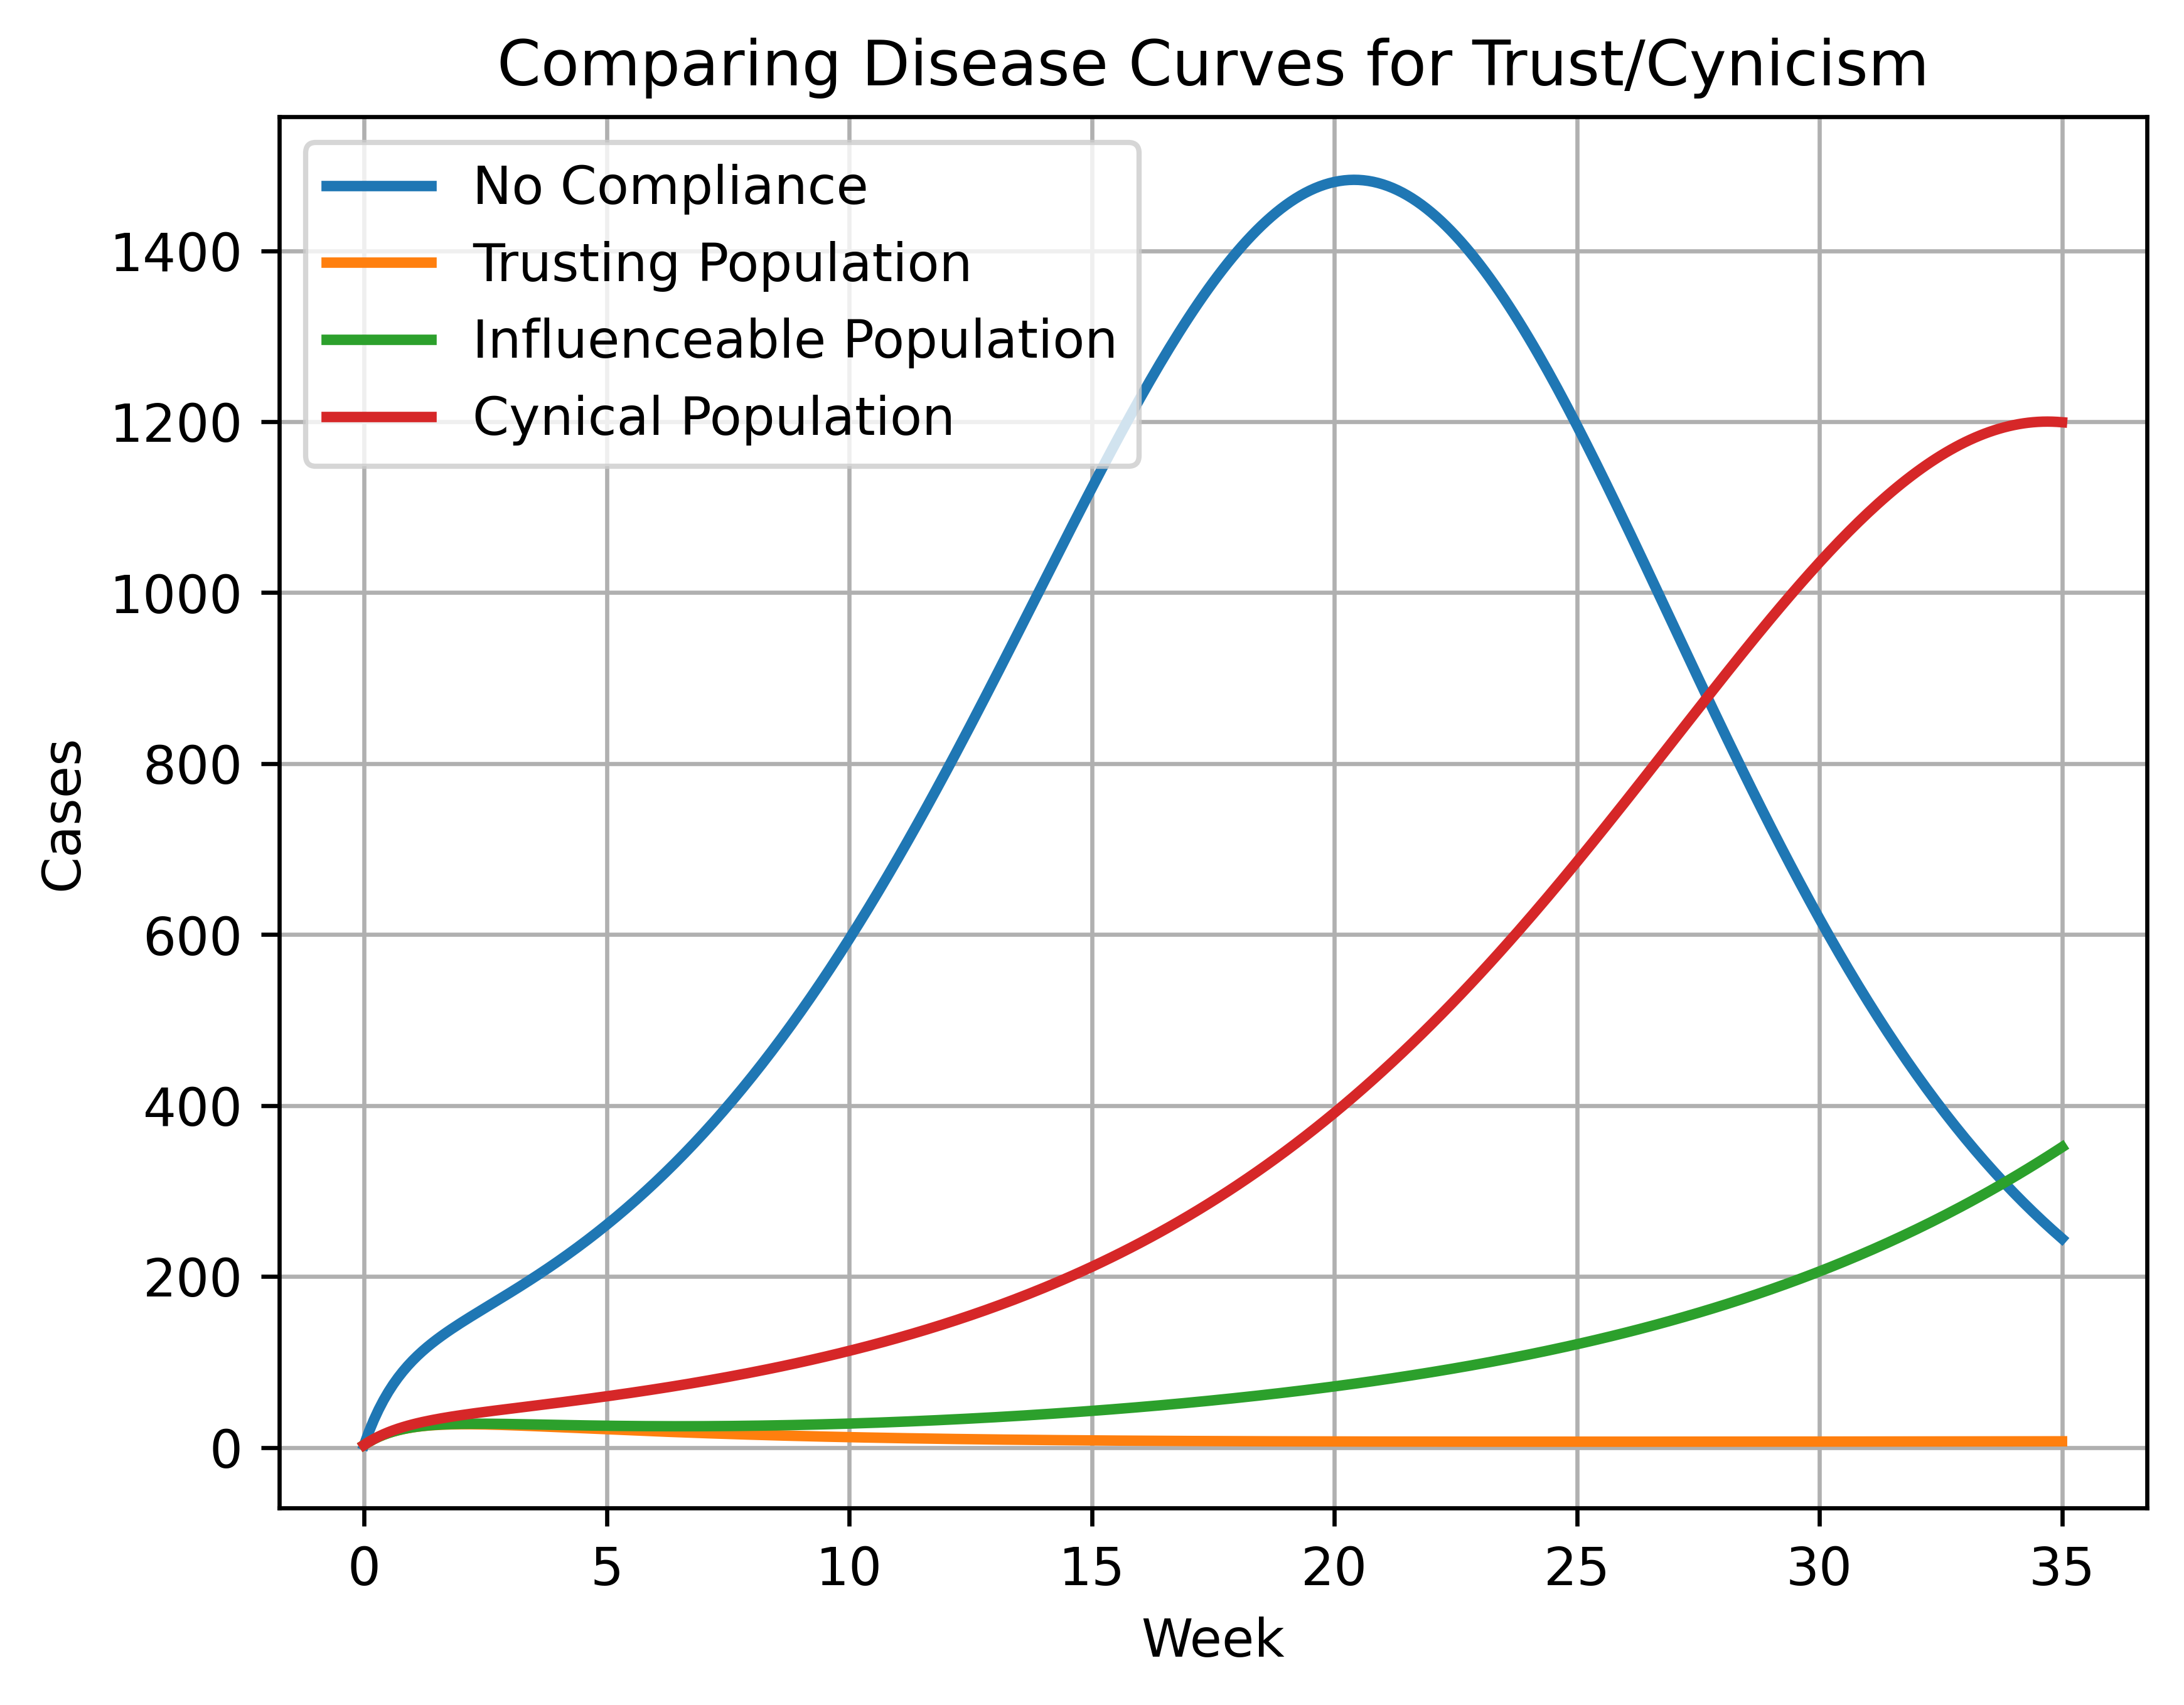

In [97]:
plt.figure(dpi=600)
plt.title('Comparing Disease Curves for Trust/Cynicism')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.plot(t, Solution1['I(t)'], label="No Compliance", linewidth=2.0)
plt.plot(t, Solution2['I(t)'], label="Trusting Population", linewidth=2.0)
plt.plot(t, Solution3['I(t)'], label="Influenceable Population", linewidth=2.0)
plt.plot(t, Solution4['I(t)'], label="Cynical Population", linewidth=2.0)
plt.grid()
plt.legend()
